In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from scipy.ndimage import zoom
import cv2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

##  Load the Trained Model

In [2]:
# Load the trained model
model_path = Path("best_model.h5")

if not model_path.exists():
    print(f"ERROR: Model not found at {model_path}")
else:
    model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
    print(f"\nModel Summary:")
    model.summary()

Model loaded successfully from best_model.h5

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,177,321 (4.49 MB)

 Trainable params: 1,175,399 (4.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2 (12.00 B)

##  Prepare Evaluation Data

In [3]:
# Load the features pickle file
features_path = Path("data_processing/tess_features.pkl")

if not features_path.exists():
    print(f"ERROR: Features file not found at {features_path}")
else:
    with open(features_path, 'rb') as f:
        data = pickle.load(f)
    
    features = data['features']
    labels = data['labels']
    label_encoder = data['label_encoder']
    emotion_list = data['emotion_list']
    
    print(f"Features loaded successfully!")
    print(f"\nDataset Info:")
    print(f"  Total samples: {features.shape[0]}")
    print(f"  Feature shape: {features.shape}")
    print(f"  Emotions: {emotion_list}")
    print(f"  Label distribution: {np.bincount(labels)}")

Features loaded successfully!

Dataset Info:
  Total samples: 2800
  Feature shape: (2800, 128, 128, 1)
  Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad']
  Label distribution: [400 400 400 400 400 400 400]


In [4]:
# Split data into train and test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

print(f"Data Split:")
print(f"  Train samples: {X_train.shape[0]} (70%)")
print(f"  Test samples: {X_test.shape[0]} (30%)")
print(f"  Train shape: {X_train.shape}")
print(f"  Test shape: {X_test.shape}")

Data Split:
  Train samples: 1960 (70%)
  Test samples: 840 (30%)
  Train shape: (1960, 128, 128, 1)
  Test shape: (840, 128, 128, 1)


##  Evaluate Model Performance

In [5]:
# Evaluate the model on test set
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70 + "\n")

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n" + "="*70)


MODEL EVALUATION

Test Loss: 0.0018
Test Accuracy: 1.0000 (100.00%)



##  Generate Classification Metrics

In [6]:
# Make predictions on test set
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print(f"Predictions generated for {len(y_pred)} test samples")

Predictions generated for 840 test samples


In [7]:
# Generate classification report
emotion_names = label_encoder.classes_

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70 + "\n")

print(classification_report(y_test, y_pred, target_names=emotion_names))

print("="*70)


CLASSIFICATION REPORT

                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00       120
          disgust       1.00      1.00      1.00       120
             fear       1.00      1.00      1.00       120
            happy       1.00      1.00      1.00       120
          neutral       1.00      1.00      1.00       120
pleasant_surprise       1.00      1.00      1.00       120
              sad       1.00      1.00      1.00       120

         accuracy                           1.00       840
        macro avg       1.00      1.00      1.00       840
     weighted avg       1.00      1.00      1.00       840



In [8]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(f"Confusion Matrix shape: {cm.shape}")
print(f"\nConfusion Matrix:\n{cm}")

Confusion Matrix shape: (7, 7)

Confusion Matrix:
[[120   0   0   0   0   0   0]
 [  0 120   0   0   0   0   0]
 [  0   0 120   0   0   0   0]
 [  0   0   0 120   0   0   0]
 [  0   0   0   0 120   0   0]
 [  0   0   0   0   0 120   0]
 [  0   0   0   0   0   0 120]]


##  Visualize Results

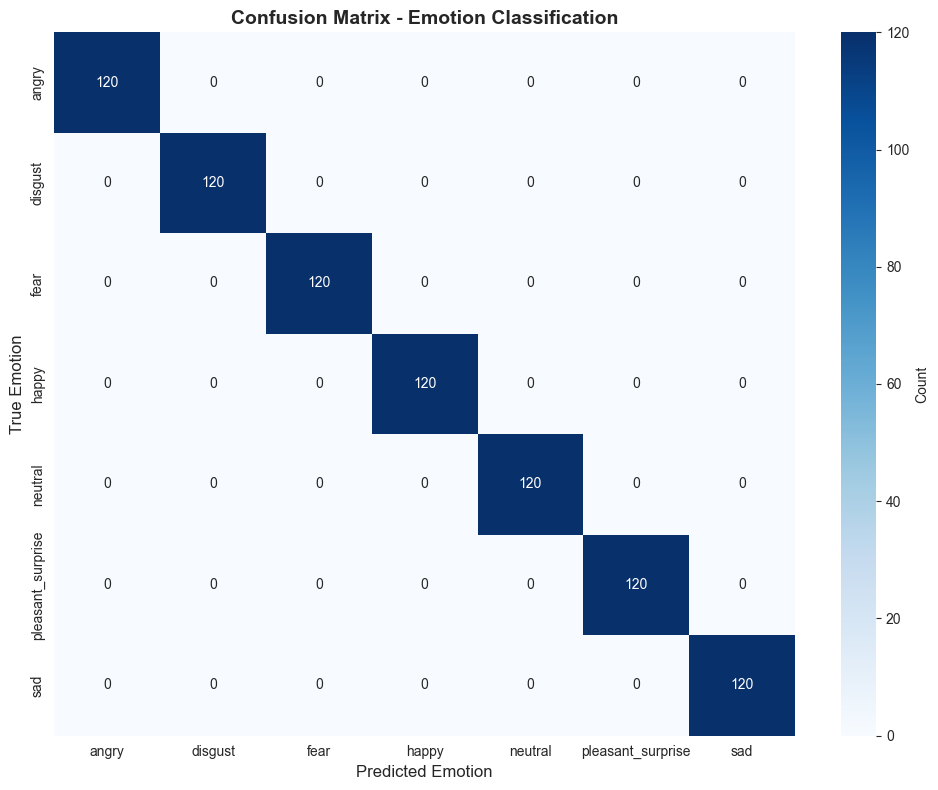

In [9]:
# Plot confusion matrix as heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_names, yticklabels=emotion_names,
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_title('Confusion Matrix - Emotion Classification', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Emotion', fontsize=12)
ax.set_ylabel('True Emotion', fontsize=12)

plt.tight_layout()
plt.show()

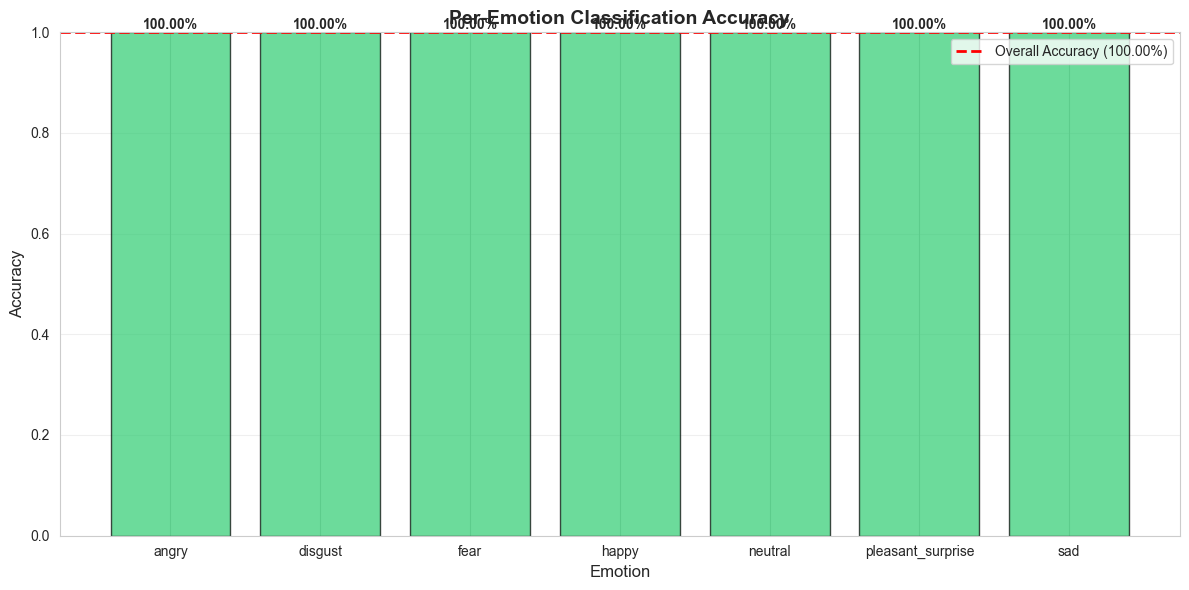

In [10]:
# Calculate per-emotion accuracy
emotions_acc = {}
for i, emotion in enumerate(emotion_names):
    mask = y_test == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == y_test[mask]).sum() / mask.sum()
        emotions_acc[emotion] = acc

# Plot accuracy per emotion
fig, ax = plt.subplots(figsize=(12, 6))

emotions = list(emotions_acc.keys())
accuracies = list(emotions_acc.values())

colors = ['#2ecc71' if acc > 0.8 else '#f39c12' if acc > 0.6 else '#e74c3c' for acc in accuracies]
bars = ax.bar(emotions, accuracies, color=colors, alpha=0.7, edgecolor='black')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Emotion', fontsize=12)
ax.set_title('Per-Emotion Classification Accuracy', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.axhline(y=accuracy, color='red', linestyle='--', label=f'Overall Accuracy ({accuracy:.2%})', linewidth=2)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
# Summary statistics
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70 + "\n")

print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")
print(f"\nPer-Emotion Accuracy:")
for emotion, acc in emotions_acc.items():
    print(f"  {emotion}: {acc*100:.2f}%")

print(f"\n" + "="*70)


EVALUATION SUMMARY

Overall Accuracy: 100.00%
Test Loss: 0.0018

Per-Emotion Accuracy:
  angry: 100.00%
  disgust: 100.00%
  fear: 100.00%
  happy: 100.00%
  neutral: 100.00%
  pleasant_surprise: 100.00%
  sad: 100.00%



##  Grad-CAM Implementation (Explainability)

Visualize what the model "sees" when making predictions using Gradient-weighted Class Activation Mapping.

In [12]:
# Build a robust Grad-CAM function that iterates layers to capture activations
def make_gradcam_heatmap(img_array, model, last_conv_layer_name=None, pred_index=None):

    # Ensure the model can run (build weights/graphs)
    inputs = tf.cast(img_array, tf.float32)

    # Auto-detect last Conv2D layer name if not provided
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break
        if last_conv_layer_name is None:
            raise ValueError("No Conv2D layer found in the model to use for Grad-CAM.")

    # Run a forward pass layer-by-layer to capture the target conv activation tensor
    x = inputs
    last_conv_output = None

    with tf.GradientTape() as tape:
        for layer in model.layers:
            x = layer(x)
            if layer.name == last_conv_layer_name:
                last_conv_output = x
                tape.watch(last_conv_output)

        # x now holds the final predictions
        preds = x
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

        # Compute gradient of the class score w.r.t. conv activations
        grads = tape.gradient(class_channel, last_conv_output)

    if last_conv_output is None:
        raise ValueError(f"Layer '{last_conv_layer_name}' not found when running the model.")

    # Global-average-pool the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the conv outputs with the pooled gradients
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to [0,1]
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.math.reduce_max(heatmap)
    if max_val == 0 or tf.math.is_nan(max_val):
        return np.zeros_like(heatmap.numpy())

    heatmap = heatmap / max_val
    return heatmap.numpy()

In [13]:
# Select "Angry" and "Sad" samples
angry_label = np.where(label_encoder.classes_ == 'angry')[0][0]
sad_label = np.where(label_encoder.classes_ == 'sad')[0][0]

# Find correctly predicted samples
angry_mask = (y_test == angry_label) & (y_pred == angry_label)
sad_mask = (y_test == sad_label) & (y_pred == sad_label)

angry_indices = np.where(angry_mask)[0]
sad_indices = np.where(sad_mask)[0]

print(f"Found {len(angry_indices)} correctly predicted 'Angry' samples")
print(f"Found {len(sad_indices)} correctly predicted 'Sad' samples")

if len(angry_indices) > 0:
    angry_sample_idx = angry_indices[0]
    print(f"\nUsing Angry sample at test index: {angry_sample_idx}")
    
if len(sad_indices) > 0:
    sad_sample_idx = sad_indices[0]
    print(f"Using Sad sample at test index: {sad_sample_idx}")

Found 120 correctly predicted 'Angry' samples
Found 120 correctly predicted 'Sad' samples

Using Angry sample at test index: 1
Using Sad sample at test index: 10


In [14]:
# Compute Grad-CAM for Angry sample
if len(angry_indices) > 0:
    angry_img = X_test[angry_sample_idx]
    angry_img_batch = np.expand_dims(angry_img, axis=0)
    
    # Compute Grad-CAM
    angry_heatmap = make_gradcam_heatmap(angry_img_batch, model, pred_index=angry_label)
    
    # Resize heatmap to match original spectrogram
    angry_heatmap_resized = zoom(angry_heatmap, (128/angry_heatmap.shape[0], 128/angry_heatmap.shape[1]))
    
    print(f"Grad-CAM computed for Angry sample")
    print(f"  Heatmap shape: {angry_heatmap_resized.shape}")

# Compute Grad-CAM for Sad sample
if len(sad_indices) > 0:
    sad_img = X_test[sad_sample_idx]
    sad_img_batch = np.expand_dims(sad_img, axis=0)
    
    # Compute Grad-CAM
    sad_heatmap = make_gradcam_heatmap(sad_img_batch, model, pred_index=sad_label)
    
    # Resize heatmap to match original spectrogram
    sad_heatmap_resized = zoom(sad_heatmap, (128/sad_heatmap.shape[0], 128/sad_heatmap.shape[1]))
    
    print(f"Grad-CAM computed for Sad sample")
    print(f"  Heatmap shape: {sad_heatmap_resized.shape}")

Grad-CAM computed for Angry sample
  Heatmap shape: (128, 128)
Grad-CAM computed for Sad sample
  Heatmap shape: (128, 128)


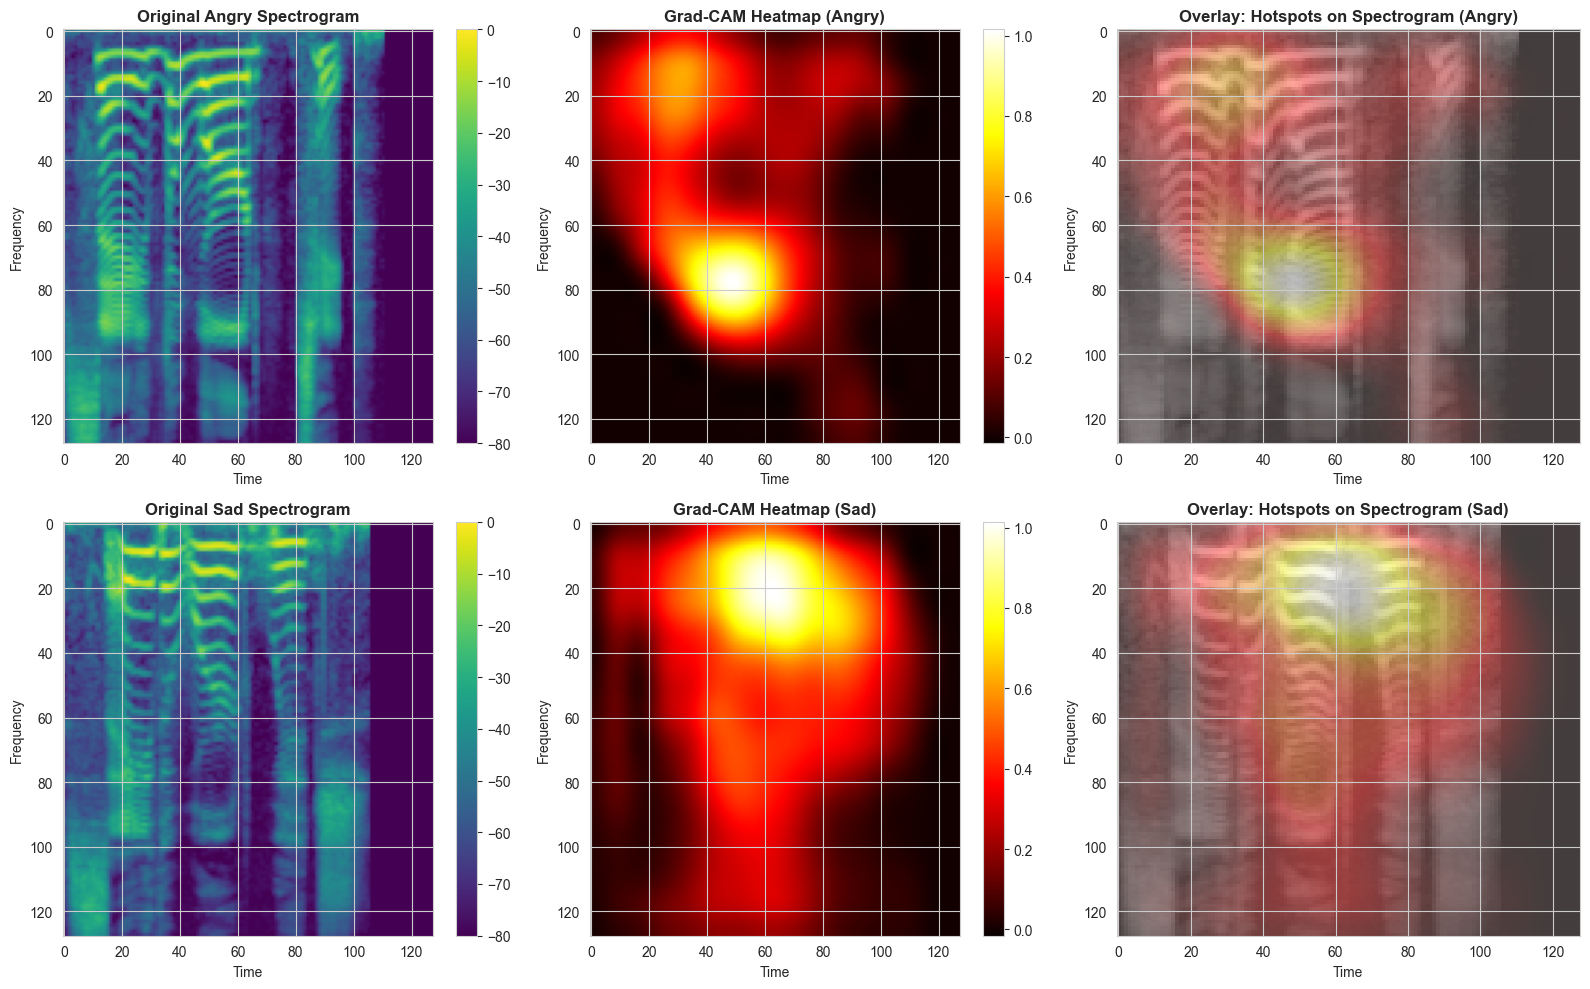

In [15]:
# Overlay Grad-CAM on Original Spectrograms
if len(angry_indices) > 0 and len(sad_indices) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Angry Sample
    angry_spec = X_test[angry_sample_idx].squeeze()
    
    # Plot 1: Original Spectrogram (Angry)
    im1 = axes[0, 0].imshow(angry_spec, cmap='viridis', aspect='auto')
    axes[0, 0].set_title('Original Angry Spectrogram', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Frequency')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Plot 2: Grad-CAM Heatmap (Angry)
    im2 = axes[0, 1].imshow(angry_heatmap_resized, cmap='hot', aspect='auto')
    axes[0, 1].set_title('Grad-CAM Heatmap (Angry)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Frequency')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # Plot 3: Overlay (Angry)
    axes[0, 2].imshow(angry_spec, cmap='gray', aspect='auto', alpha=0.6)
    axes[0, 2].imshow(angry_heatmap_resized, cmap='hot', aspect='auto', alpha=0.4)
    axes[0, 2].set_title('Overlay: Hotspots on Spectrogram (Angry)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('Time')
    axes[0, 2].set_ylabel('Frequency')
    
    # Sad Sample
    sad_spec = X_test[sad_sample_idx].squeeze()
    
    # Plot 4: Original Spectrogram (Sad)
    im4 = axes[1, 0].imshow(sad_spec, cmap='viridis', aspect='auto')
    axes[1, 0].set_title('Original Sad Spectrogram', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Frequency')
    plt.colorbar(im4, ax=axes[1, 0])
    
    # Plot 5: Grad-CAM Heatmap (Sad)
    im5 = axes[1, 1].imshow(sad_heatmap_resized, cmap='hot', aspect='auto')
    axes[1, 1].set_title('Grad-CAM Heatmap (Sad)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Frequency')
    plt.colorbar(im5, ax=axes[1, 1])
    
    # Plot 6: Overlay (Sad)
    axes[1, 2].imshow(sad_spec, cmap='gray', aspect='auto', alpha=0.6)
    axes[1, 2].imshow(sad_heatmap_resized, cmap='hot', aspect='auto', alpha=0.4)
    axes[1, 2].set_title('Overlay: Hotspots on Spectrogram (Sad)', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Time')
    axes[1, 2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough Angry or Sad samples to visualize")

## Grad-CAM Interpretation

The Grad-CAM visualizations show **which regions of the spectrogram the model focuses on** when making predictions:

- **Red/Yellow hotspots**: Regions important for the prediction
- **Dark regions**: Less important regions
- **Overlay**: Shows how attention aligns with the spectrogram features

### Key Insights:
- **Angry emotion**: Model may focus on high-frequency components or rapid changes
- **Sad emotion**: Model may focus on different frequency ranges or patterns

This explains **"WHY"** the model makes each prediction!